In [1]:
%%capture
import os
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    # Do this only in Colab notebooks! Otherwise use pip install unsloth
    !pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft trl triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf "datasets>=3.4.1" huggingface_hub hf_transfer
    !pip install --no-deps unsloth

In [2]:
from unsloth import FastLanguageModel
import torch

fourbit_models = [
    "unsloth/Qwen3-1.7B-unsloth-bnb-4bit", # Qwen 14B 2x faster
    "unsloth/Qwen3-4B-unsloth-bnb-4bit",
    "unsloth/Qwen3-8B-unsloth-bnb-4bit",
    "unsloth/Qwen3-14B-unsloth-bnb-4bit",
    "unsloth/Qwen3-32B-unsloth-bnb-4bit",

    # 4bit dynamic quants for superior accuracy and low memory use
    "unsloth/gemma-3-12b-it-unsloth-bnb-4bit",
    "unsloth/Phi-4",
    "unsloth/Llama-3.1-8B",
    "unsloth/Llama-3.2-3B",
    "unsloth/orpheus-3b-0.1-ft-unsloth-bnb-4bit" # [NEW] We support TTS models!
] # More models at https://huggingface.co/unsloth

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Qwen3-14B",
    max_seq_length = 2048,   # Context length - can be longer, but uses more memory
    load_in_4bit = True,     # 4bit uses much less memory
    load_in_8bit = False,    # A bit more accurate, uses 2x memory
    full_finetuning = False, # We have full finetuning now!
    # token = "hf_...",      # use one if using gated models
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


2025-07-04 09:51:49.850645: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751622710.081262      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751622710.153882      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.6.12: Fast Qwen3 patching. Transformers: 4.51.3.
   \\   /|    Tesla P100-PCIE-16GB. Num GPUs = 1. Max memory: 15.888 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 6.0. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.59G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/1.56G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/237 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/707 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

In [3]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 128,           # Choose any number > 0! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 128,  # Best to choose alpha = rank or rank*2
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,   # We support rank stabilized LoRA
    loftq_config = None,  # And LoftQ
)

Unsloth 2025.6.12 patched 40 layers with 40 QKV layers, 40 O layers and 40 MLP layers.


In [4]:
import pandas as pd

In [5]:
df=pd.read_csv("/kaggle/input/ieee-cs-ml-contest2025/train.csv")

In [6]:
df.head()

,id,question,options,answer
0,470f20ff-2f48-44a6-a2ad-241df10ec87d-103644,অপবর্তন এক বিশেষ ধরনের—,['সমবর্তন' 'প্রতিফলন' 'ব্যাতিচার' 'প্রতিসরণ'],C
1,c08f0631-b9ac-4c46-a232-a08476e15f86-128154,50 kg ভরের কোনো বস্তুর ভরবেগ 200 kgms-1 হলে বস...,['200 J' '300 J' '400 J' '500 J'],C
2,8198bcf6-2fd5-411f-be00-b925f6190b8b-119159,একটি প্রিজমের প্রিজম কোণ 60০ ও নূন্যতম বিচ্যুত...,['2.26' '3.21' '1.41' '5.25'],C
3,138ebd19-ffd7-4153-891d-713dc4b7c835-132542,4 kg ভরের একটি বস্তুকে 10ms-2 ত্বরণে গতিশীল কর...,['60N' '70N' '50N' '80N'],C
4,1b1078ad-f450-4ef9-bc6d-9da968456127-95922,1 ইলেকট্রন ভোল্ট (1 eV) হলো—,['1.6 × 10-9 J ' '1.6 × 109 J' '1.6 × 10-19 J'...,C


In [7]:
df_test= pd.read_csv("/kaggle/input/ieee-cs-ml-contest2025/test.csv")
df_test

,id,question,options
0,1,কোনো বস্তুর চৌম্বকত্ব ধারকত্ব পরিমাপ করা হয়-,['চুম্বকনকারি বলা হয় ' 'সম্পৃক্ত দ্বারা ' 'আবি...
1,2,একটি বুলেট লক্ষ বস্তুর 3 cm ভেতরে প্রবেশ করতে ...,['1cm' '1m' '2 cm' '2 m']
2,3,"একটি সরল দোলকের দোলনকাল T, দৈর্ঘ্য দ্বিগুণ হলে...",['2T' '`T/sqrt2`' '`T/2`' '`sqrt2T`']
3,4,একটি রকেট ঊর্ধমুখী যাত্রায় প্রথম 2 সেকেন্ড এর ...,['36 ms-2' '20.2 ms-2' '15.2 ms-2' '30 ms-2']
4,5,50 পাকের একটি বৃত্তাকার কুন্ডলীর ব্যাস 30 cm। ...,['4.7 × 10-5 A' '0.48 A' '47 A' '94 A']
...,...,...,...
195,196,একটি বালের গায়ে 100W-200V লেখা। এর রোধ কত?,['200Ω' '300Ω' '400Ω' '500Ω']
196,197,যে বৈশিষ্ট্য দ্বারা একটি শব্দ অন্য একটি শব্দ হ...,['তীব্রতা' 'স্বরকম্প' 'স্বরগ্রাম' 'শব্দোচ্চতা']
197,198,16 বিবর্ধন বিশিষ্ট নভো-দূরবীক্ষন যন্তের লেন্সে...,"['100 cm, 10 cm' '80 cm, 5 cm' '200 cm, 2 cm' ..."
198,199,একটি তারের প্রস্থচ্ছেদ এর ক্ষেত্রফল 0.003 m2 ।...,['102kg' '102 নিউটন ' '9.8 ×102kg' '9.8×102 নি...


In [8]:
import pandas as pd
import ast
import re

# Safe eval with fallback fix for malformed option strings
def safe_eval_options(option_str):
    try:
        # Fix: missing commas between quoted options → `'A' 'B'` → `'A', 'B'`
        fixed = re.sub(r"'\s*'", "', '", option_str.strip())
        return ast.literal_eval(fixed)
    except:
        return None

# Updated prompt generator — never drops row
def format_prompt(row):
    options = safe_eval_options(row['options'])
    if options is None or len(options) != 4:
        # Return fallback string so we don't lose rows
        return f"Question: {row['question']}\nOptions could not be parsed."
    
    # Normal case
    formatted_options = "".join([
        f"A. {options[0]}",
        f"B. {options[1]}",
        f"C. {options[2]}",
        f"D. {options[3]}"
    ])
    return f"Question: {row['question']}{formatted_options}"

# Apply
df_test["cleaned"] = df_test.apply(format_prompt, axis=1)

# Confirm row count
print("Cleaned rows:", len(df_test))  

Cleaned rows: 200


In [9]:
df_test['cleaned'][0]

'Question: কোনো বস্তুর চৌম্বকত্ব ধারকত্ব পরিমাপ করা হয়-A. চুম্বকনকারি বলা হয় B. সম্পৃক্ত দ্বারা C. আবিষ্ট চুম্বকত্ব দ্বারা D. উপরের কোনোটিই নয় '

In [10]:
from unsloth.chat_templates import get_chat_template
import pandas as pd
import torch
import re

prompt_template = """You are a physics expert. Analyze this question carefully:

{question}

Instructions:
1. Think step by step to determine the correct answer
2. Use detailed reasoning only if the question involves calculations or formulas
3. For conceptual or theory-based questions, stick to standard textbook definitions and do not overanalyze
4. Select ONLY the letter (A, B, C, or D) of the correct option
5. Your response must be exactly one character: A, B, C, or D

Answer:"""
# prompt_template = """আপনি একজন পদার্থবিজ্ঞানের বিশেষজ্ঞ। নিচের প্রশ্নটি মনোযোগ সহকারে বিশ্লেষণ করুন:

# {question}

# নির্দেশনা:
# 1. ধাপে ধাপে চিন্তা করুন এবং সঠিক উত্তর বের করুন
# 2. যদি প্রশ্নটিতে গণনা বা সূত্র প্রয়োজন হয়, তবে বিশদভাবে বিশ্লেষণ করুন
# 3. যদি এটি তাত্ত্বিক প্রশ্ন হয়, তাহলে পাঠ্যবই অনুযায়ী ব্যাখ্যা দিন
# 4. কেবলমাত্র সঠিক অপশনের বর্ণ (A, B, C, অথবা D) নির্বাচন করুন
# 5. আপনার উত্তর হবে শুধু একটি বড় হাতের অক্ষর: A, B, C অথবা D

# উত্তর:"""

clean_answers = []
raw_answers = []
full_prompts = []
full_responses = []

model.eval()
model.config.use_cache = True

device = next(model.parameters()).device
print(f"⚙️ Using device: {device}\n")

for idx, text in enumerate(df_test['cleaned']):
    try:
        prompt = prompt_template.format(question=text)
        full_prompts.append(prompt)

        messages = [{"role": "user", "content": prompt}]

        inputs = tokenizer.apply_chat_template(
            messages,
            add_generation_prompt=True,
            tokenize=True,
            return_tensors="pt"
        ).to(device)

        with torch.no_grad():
            with torch.backends.cuda.sdp_kernel(enable_flash=False):
                outputs = model.generate(
                    input_ids=inputs,
                    max_new_tokens=3000,
                    temperature=0.05,
                    top_p=0.90,
                    top_k=60,
                    do_sample=True,
                )

        full_output = tokenizer.decode(outputs[0], skip_special_tokens=False)
        full_responses.append(full_output)

        response_start = full_output.find("[/INST]") + len("[/INST]")
        response_end = full_output.find("</s>", response_start)
        response_section = full_output[response_start:response_end].strip()

        # Step 1: Try to extract from "The correct answer is: X" or similar
        answer = "X"
        raw_response = response_section
        for line in reversed(response_section.splitlines()):
            line = line.strip()
            match = re.search(r"correct answer\s+is[:\s]*([A-D])\b", line, re.IGNORECASE)
            if match:
                answer = match.group(1).upper()
                break
            # Try "Answer: X" or "Ans: X"
            match = re.search(r"^ans(?:wer)?[:\s]*([A-D])\b", line, re.IGNORECASE)
            if match:
                answer = match.group(1).upper()
                break
        
        # Step 2: Fallback regex — look for isolated A-D
        if answer == "X":
            match = re.findall(r"\b([A-D])\b", response_section.upper())
            if match:
                # Take the last one in case multiple options are discussed
                answer = match[-1]


        

        print(f"\n{'='*50}")
        print(f"📌 Question #{idx+1}:")
        print(f"\n💬 Prompt:\n{prompt}")
        print(f"\n🤖 Full Model Output:\n{full_output}")
        print(f"\n🔍 Response Section:\n{response_section}")
        print(f"\n✅ Final Answer: {answer}")

    except Exception as e:
        print(f"\n⚠️ Error processing question #{idx+1}: {str(e)}")
        raw_response = f"ERROR: {str(e)}"
        answer = "X"
        full_output = ""
        full_responses.append(full_output)

    raw_answers.append(raw_response)
    clean_answers.append(answer)

# Save results
df_test['full_prompt'] = full_prompts
df_test['full_model_output'] = full_responses
df_test['raw_answer'] = raw_answers
df_test['answer'] = clean_answers
print("\n\n📊 Final Results Summary:")
print(df_test[['id', 'answer', 'raw_answer']].head())

df_test[['id', 'answer']].to_csv("submission.csv", index=False)
df_test.to_csv("detailed_predictions.csv", index=False)

print("\n✅ Saved outputs.")

/usr/lib/python3.11/contextlib.py:105: FutureWarning: `torch.backends.cuda.sdp_kernel()` is deprecated. In the future, this context manager will be removed. Please see `torch.nn.attention.sdpa_kernel()` for the new context manager, with updated signature.
  self.gen = func(*args, **kwds)
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


⚙️ Using device: cuda:0


📌 Question #1:

💬 Prompt:
You are a physics expert. Analyze this question carefully:

Question: কোনো বস্তুর চৌম্বকত্ব ধারকত্ব পরিমাপ করা হয়-A. চুম্বকনকারি বলা হয় B. সম্পৃক্ত দ্বারা C. আবিষ্ট চুম্বকত্ব দ্বারা D. উপরের কোনোটিই নয় 

Instructions:
1. Think step by step to determine the correct answer
2. Use detailed reasoning only if the question involves calculations or formulas
3. For conceptual or theory-based questions, stick to standard textbook definitions and do not overanalyze
4. Select ONLY the letter (A, B, C, or D) of the correct option
5. Your response must be exactly one character: A, B, C, or D

Answer:

🤖 Full Model Output:
<|im_start|>user
You are a physics expert. Analyze this question carefully:

Question: কোনো বস্তুর চৌম্বকত্ব ধারকত্ব পরিমাপ করা হয়-A. চুম্বকনকারি বলা হয় B. সম্পৃক্ত দ্বারা C. আবিষ্ট চুম্বকত্ব দ্বারা D. উপরের কোনোটিই নয় 

Instructions:
1. Think step by step to determine the correct answer
2. Use detailed reasoning only if the q

/usr/lib/python3.11/contextlib.py:105: FutureWarning: `torch.backends.cuda.sdp_kernel()` is deprecated. In the future, this context manager will be removed. Please see `torch.nn.attention.sdpa_kernel()` for the new context manager, with updated signature.
  self.gen = func(*args, **kwds)



📌 Question #2:

💬 Prompt:
You are a physics expert. Analyze this question carefully:

Question: একটি বুলেট লক্ষ বস্তুর 3 cm ভেতরে প্রবেশ করতে তার অর্ধেক বেগ হারায়। লক্ষ্য বস্তুর প্রতিরোধ সুষম হলে আর কতদূর এটি প্রবেশ করবে?A. 1cmB. 1mC. 2 cmD. 2 m

Instructions:
1. Think step by step to determine the correct answer
2. Use detailed reasoning only if the question involves calculations or formulas
3. For conceptual or theory-based questions, stick to standard textbook definitions and do not overanalyze
4. Select ONLY the letter (A, B, C, or D) of the correct option
5. Your response must be exactly one character: A, B, C, or D

Answer:

🤖 Full Model Output:
<|im_start|>user
You are a physics expert. Analyze this question carefully:

Question: একটি বুলেট লক্ষ বস্তুর 3 cm ভেতরে প্রবেশ করতে তার অর্ধেক বেগ হারায়। লক্ষ্য বস্তুর প্রতিরোধ সুষম হলে আর কতদূর এটি প্রবেশ করবে?A. 1cmB. 1mC. 2 cmD. 2 m

Instructions:
1. Think step by step to determine the correct answer
2. Use detailed reasoning only 

/usr/lib/python3.11/contextlib.py:105: FutureWarning: `torch.backends.cuda.sdp_kernel()` is deprecated. In the future, this context manager will be removed. Please see `torch.nn.attention.sdpa_kernel()` for the new context manager, with updated signature.
  self.gen = func(*args, **kwds)



📌 Question #16:

💬 Prompt:
You are a physics expert. Analyze this question carefully:

Question: i-49 এর মান:-A. -1B. iC. 1D. -i

Instructions:
1. Think step by step to determine the correct answer
2. Use detailed reasoning only if the question involves calculations or formulas
3. For conceptual or theory-based questions, stick to standard textbook definitions and do not overanalyze
4. Select ONLY the letter (A, B, C, or D) of the correct option
5. Your response must be exactly one character: A, B, C, or D

Answer:

🤖 Full Model Output:
<|im_start|>user
You are a physics expert. Analyze this question carefully:

Question: i-49 এর মান:-A. -1B. iC. 1D. -i

Instructions:
1. Think step by step to determine the correct answer
2. Use detailed reasoning only if the question involves calculations or formulas
3. For conceptual or theory-based questions, stick to standard textbook definitions and do not overanalyze
4. Select ONLY the letter (A, B, C, or D) of the correct option
5. Your response

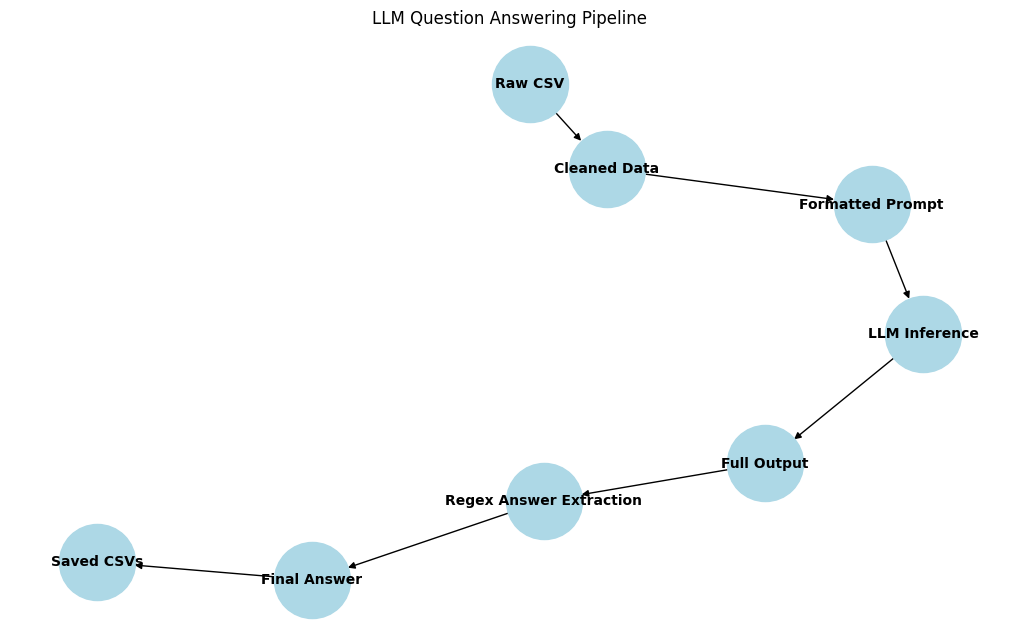

In [11]:
import matplotlib.pyplot as plt
import networkx as nx

G = nx.DiGraph()
G.add_edges_from([
    ("Raw CSV", "Cleaned Data"),
    ("Cleaned Data", "Formatted Prompt"),
    ("Formatted Prompt", "LLM Inference"),
    ("LLM Inference", "Full Output"),
    ("Full Output", "Regex Answer Extraction"),
    ("Regex Answer Extraction", "Final Answer"),
    ("Final Answer", "Saved CSVs"),
])

plt.figure(figsize=(10,6))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_size=3000, node_color='lightblue', font_size=10, font_weight='bold', arrows=True)
plt.title("LLM Question Answering Pipeline")
plt.show()


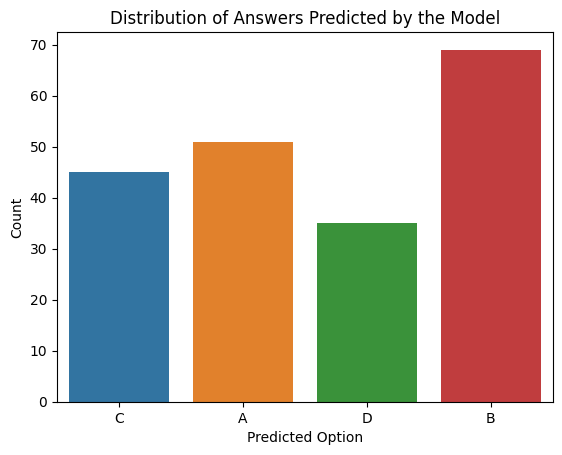

In [12]:
import seaborn as sns

sns.countplot(x='answer', data=df_test)
plt.title("Distribution of Answers Predicted by the Model")
plt.xlabel("Predicted Option")
plt.ylabel("Count")
plt.show()
